# East coast floods


In [104]:
import os
import datetime

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_CAFE-c5-d60-pX-f6_19950501-20201101_base-1995-2020.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CAFE-c5-d60-pX-f6_1995-2020_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CAFE-c5-d60-pX-f6_1995-2020_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "CAFE"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/CAFE_c5-d60-pX-f6_files.txt"


In [113]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19950501/atmos_isobaric_daily.zarr.zip'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [15]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

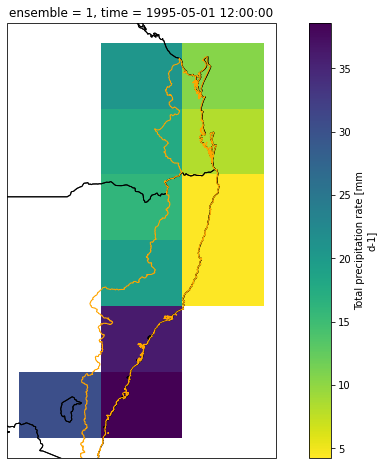

In [16]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [17]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [18]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 96, init_date: 52, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Data variables:
    pr          (init_date, lead_time, ensemble) float64 dask.array<chunksize=(1, 11, 96), meta=np.ndarray>
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    history:    Thu Jan 05 08:55:25 2023: /g/data/xv83/dbi599/miniconda3/envs...
    title:      AccessOcean-AM2

### Independence testing

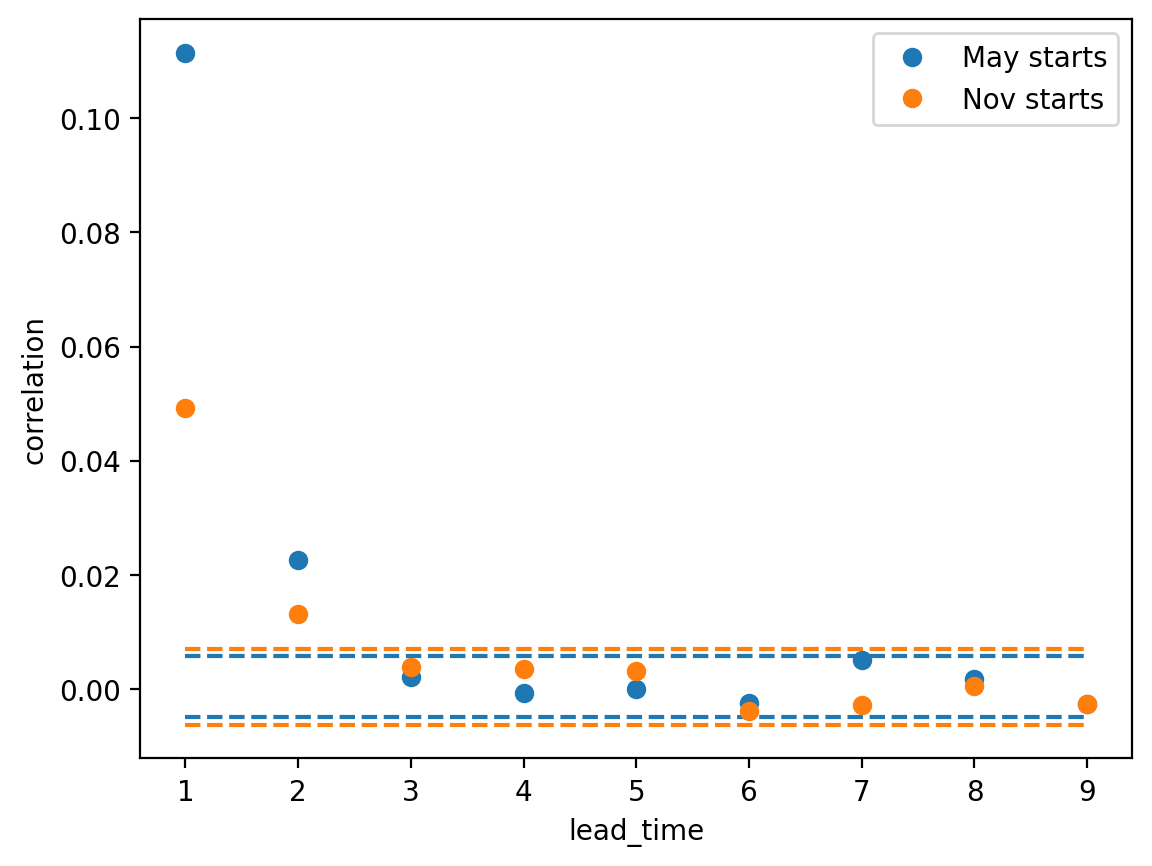

In [19]:
Image(filename=independence_plot)

In [20]:
print(min_lead)

1


In [21]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

In [22]:
model_da

<xarray.DataArray 'pr' (init_date: 52, lead_time: 11, ensemble: 96)>
dask.array<where, shape=(52, 11, 96), dtype=float64, chunksize=(1, 11, 96), chunktype=numpy.ndarray>
Coordinates:
  * ensemble    (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 89 90 91 92 93 94 95 96
    event_time  (init_date, lead_time, ensemble) <U28 dask.array<chunksize=(52, 11, 96), meta=np.ndarray>
  * init_date   (init_date) object 1995-05-01 00:00:00 ... 2020-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 52), meta=np.ndarray>
Attributes:
    cell_methods:   time: mean
    interp_method:  conserve_order1
    long_name:      Total precipitation rate
    time_avg_info:  average_T1,average_T2,average_DT
    units:          mm d-1

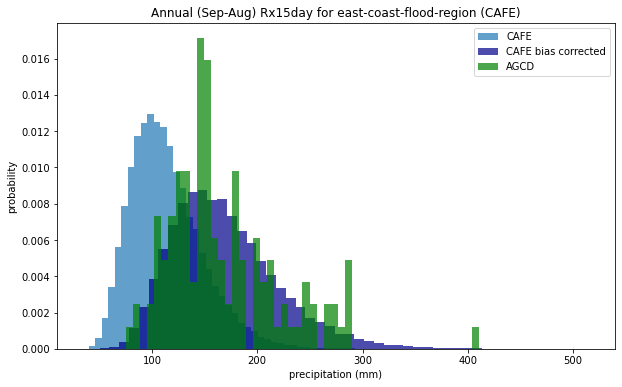

In [23]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
agcd_ds['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [24]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [25]:
similarity_raw_ds['ks_pval'].values

array([4.5100378e-06, 2.2608257e-09, 3.1694092e-10, 2.0319471e-09,
       1.8449137e-08, 1.7187098e-08, 1.4488616e-08, 1.8449137e-08,
       1.6237811e-08], dtype=float32)

In [26]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [27]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [28]:
similarity_bias_ds['ks_pval'].values

array([0.70153797, 0.8164515 , 0.890162  , 0.706683  , 0.6635799 ,
       0.6549238 , 0.74901956, 0.51892614, 0.575773  ], dtype=float32)

In [29]:
similarity_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
      dtype=float32)

### Exceedance curves

In [30]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [31]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period\n')

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [32]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [33]:
model_bc_da_stacked.shape

(44928,)

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CAFE.png


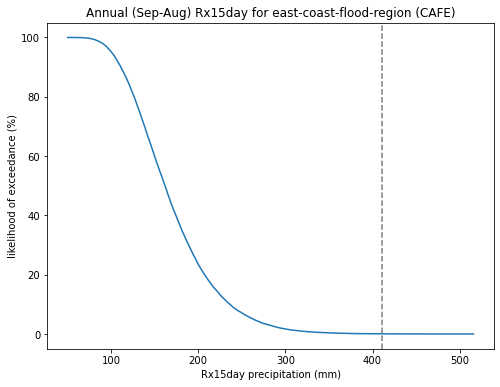

In [34]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [35]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
24 events in 44928 samples
99.95% percentile
1872 year return period


1995-1999
1 events in 1920 samples
99.95% percentile
1920 year return period

2000-2004
2 events in 6720 samples
99.97% percentile
3360 year return period

2005-2009
5 events in 8640 samples
99.94% percentile
1728 year return period

2010-2014
6 events in 8640 samples
99.93% percentile
1440 year return period

2015-2019
4 events in 8640 samples
99.95% percentile
2160 year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CAFE_by-decade.png


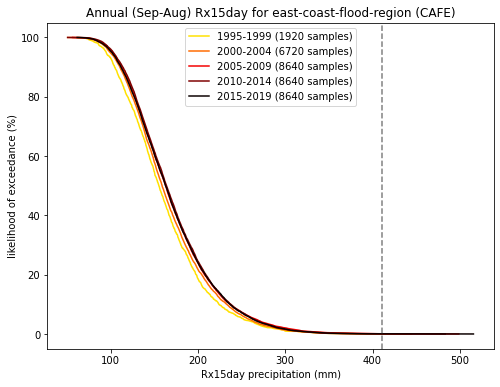

In [36]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

In [37]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [38]:
model_da_stacked.shape

(44928,)

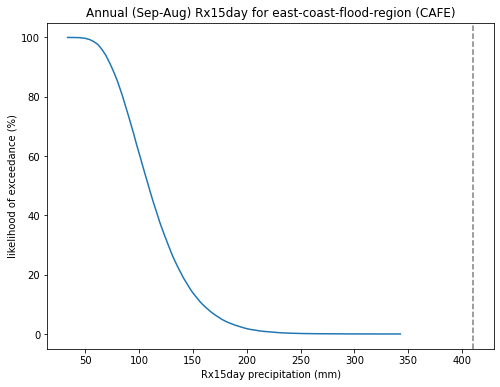

In [39]:
plot_exceedance(model_da_stacked, model_name)

In [40]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 44928 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


### Seasonality

In [70]:
model_df = model_ds['pr'].to_dataframe()
model_df = model_df.dropna()
model_df = model_df.reset_index()
model_df['init_date'] = model_df['init_date'].apply(lambda x: x.strftime('%Y%m'))
model_df

,init_date,lead_time,ensemble,event_time,time,pr
0,199505,1,1,1996-01-23,1996-05-01 12:00:00,97.194399
1,199505,1,2,1996-02-21,1996-05-01 12:00:00,158.678279
2,199505,1,3,1995-12-10,1996-05-01 12:00:00,142.830538
3,199505,1,4,1996-03-03,1996-05-01 12:00:00,139.639970
4,199505,1,5,1995-09-19,1996-05-01 12:00:00,92.458357
...,...,...,...,...,...,...
44923,202011,9,92,2030-02-03,2029-11-01 12:00:00,77.183919
44924,202011,9,93,2029-12-28,2029-11-01 12:00:00,119.817343
44925,202011,9,94,2029-12-17,2029-11-01 12:00:00,98.297948
44926,202011,9,95,2030-04-26,2029-11-01 12:00:00,189.280392


In [42]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

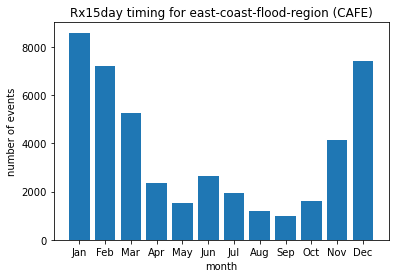

In [43]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [76]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (ensemble: 96, init_date: 52, lead_time: 120)
Coordinates:
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
  * init_date  (init_date) <U6 '199505' '199511' '199605' ... '202005' '202011'
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
    time       (lead_time, init_date) object dask.array<chunksize=(120, 52), meta=np.ndarray>
Data variables:
    tos        (init_date, lead_time, ensemble) float32 dask.array<chunksize=(1, 3, 96), meta=np.ndarray>
Attributes:
    history:  Fri Jan 06 11:31:36 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [103]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date']
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [105]:
model_df['nino34'] = nino_values

In [106]:
model_df

,init_date,lead_time,ensemble,event_time,time,pr,nino34
0,199505,1,1,1996-01-23,1996-05-01 12:00:00,97.194399,-0.771542
1,199505,1,2,1996-02-21,1996-05-01 12:00:00,158.678279,-0.426529
2,199505,1,3,1995-12-10,1996-05-01 12:00:00,142.830538,-0.055088
3,199505,1,4,1996-03-03,1996-05-01 12:00:00,139.639970,-0.744141
4,199505,1,5,1995-09-19,1996-05-01 12:00:00,92.458357,0.459641
...,...,...,...,...,...,...,...
44923,202011,9,92,2030-02-03,2029-11-01 12:00:00,77.183919,-0.830437
44924,202011,9,93,2029-12-28,2029-11-01 12:00:00,119.817343,-0.622221
44925,202011,9,94,2029-12-17,2029-11-01 12:00:00,98.297948,0.597351
44926,202011,9,95,2030-04-26,2029-11-01 12:00:00,189.280392,3.106680


/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


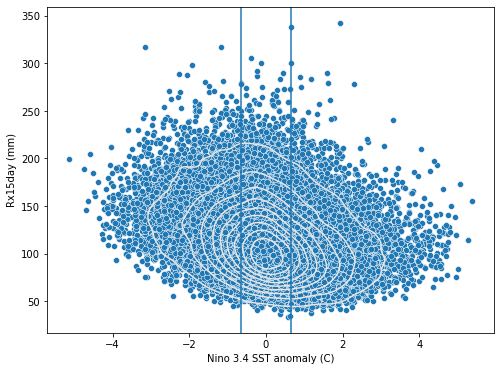

In [112]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [44]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [45]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)

In [46]:
ranked_events.head(n=10)

,init_date,lead_time,ensemble,event_time,time,pr
28829,2011-11-01 00:00:00,4,30,2016-02-17,2015-11-01 12:00:00,342.611730
9300,2000-05-01 00:00:00,7,85,2007-03-13,2007-05-01 12:00:00,338.352156
5192,1998-05-01 00:00:00,1,9,1998-12-16,1999-05-01 12:00:00,317.690931
17243,2004-11-01 00:00:00,9,60,2014-03-25,2013-11-01 12:00:00,316.928423
7471,1999-05-01 00:00:00,6,80,2004-12-21,2005-05-01 12:00:00,305.218342
40260,2018-05-01 00:00:00,6,37,2024-02-12,2024-05-01 12:00:00,300.254011
28438,2011-05-01 00:00:00,9,23,2020-02-01,2020-05-01 12:00:00,300.038223
388,1995-05-01 00:00:00,5,5,2000-01-09,2000-05-01 12:00:00,298.074731
23383,2008-11-01 00:00:00,1,56,2010-02-23,2009-11-01 12:00:00,291.499529
42236,2019-05-01 00:00:00,8,93,2027-02-17,2027-05-01 12:00:00,290.401339


In [47]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,lead_time,ensemble,event_time,time,pr
28829,2011-11-01 00:00:00,4,30,2016-02-17,2015-11-01 12:00:00,515.651429
9300,2000-05-01 00:00:00,7,85,2007-03-13,2007-05-01 12:00:00,498.802202
17243,2004-11-01 00:00:00,9,60,2014-03-25,2013-11-01 12:00:00,483.364569
7471,1999-05-01 00:00:00,6,80,2004-12-21,2005-05-01 12:00:00,459.509215
28438,2011-05-01 00:00:00,9,23,2020-02-01,2020-05-01 12:00:00,453.210301
40260,2018-05-01 00:00:00,6,37,2024-02-12,2024-05-01 12:00:00,452.035365
388,1995-05-01 00:00:00,5,5,2000-01-09,2000-05-01 12:00:00,444.784249
42236,2019-05-01 00:00:00,8,93,2027-02-17,2027-05-01 12:00:00,440.972969
5192,1998-05-01 00:00:00,1,9,1998-12-16,1999-05-01 12:00:00,438.126338
32698,2013-11-01 00:00:00,8,59,2022-03-03,2021-11-01 12:00:00,435.080435


20111101 (2016-02-17), ensemble:30, 342.6117297748746mm


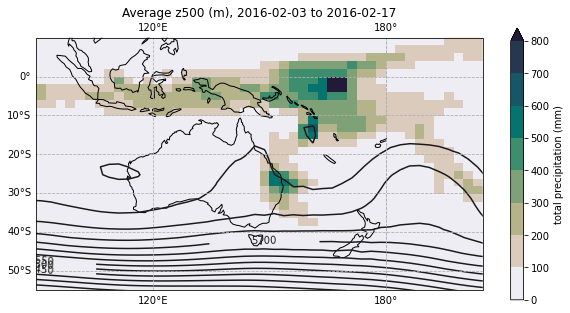

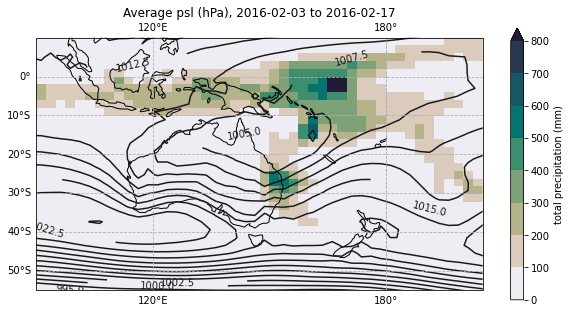

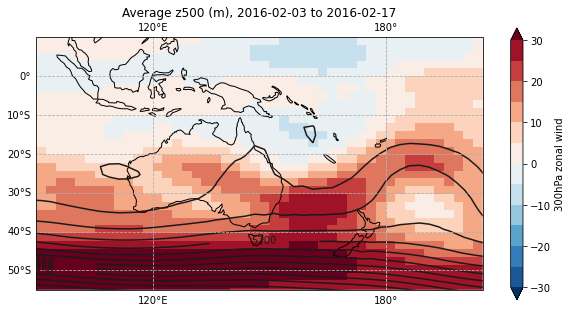

20000501 (2007-03-13), ensemble:85, 338.3521560943671mm


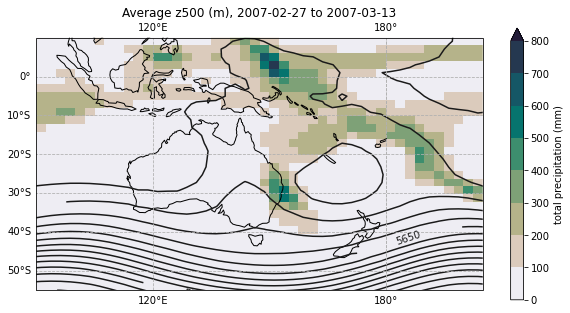

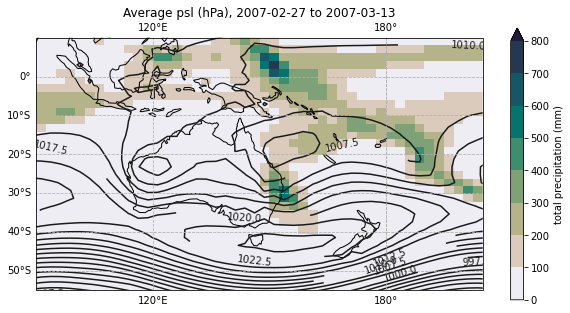

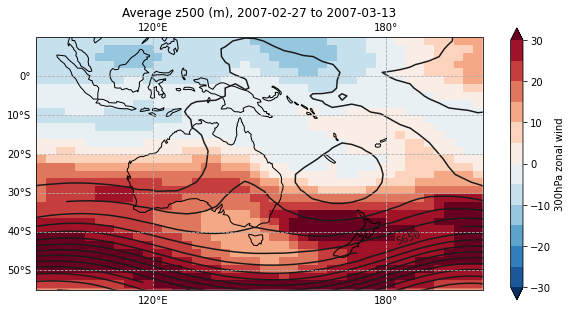

19980501 (1998-12-16), ensemble:9, 317.69093092849295mm


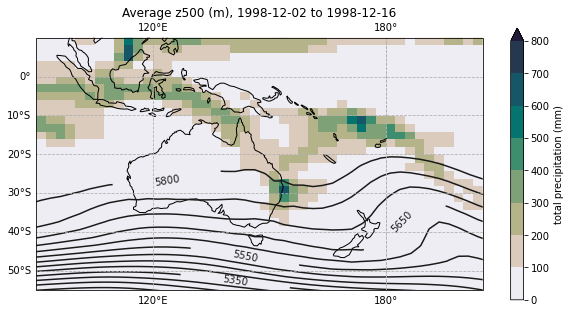

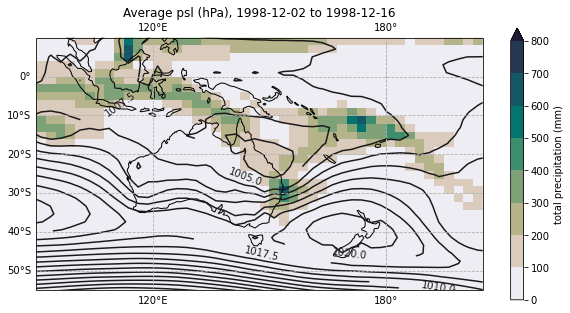

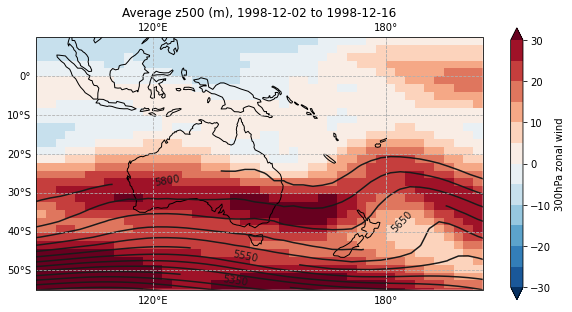

20041101 (2014-03-25), ensemble:60, 316.9284229462225mm


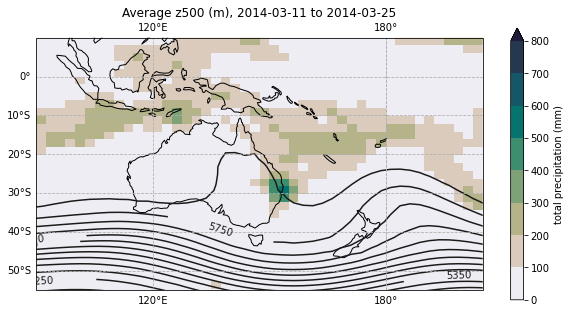

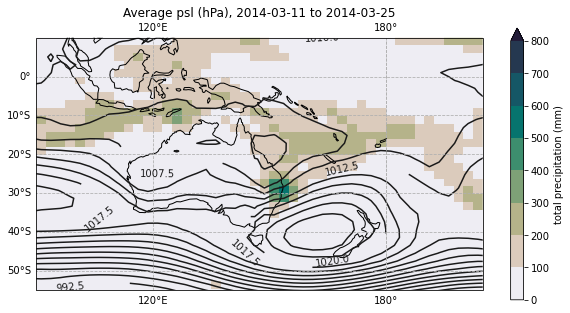

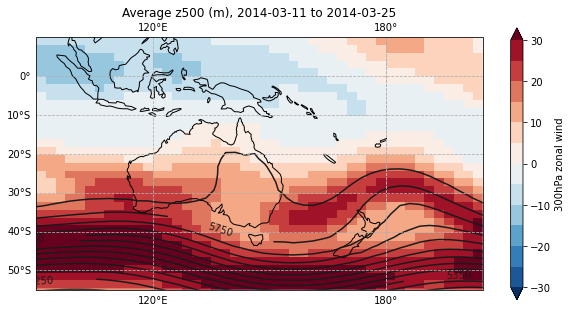

In [48]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = row['init_date'].strftime('%Y%m%d')
    ensemble = row['ensemble']
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble:{ensemble}, {rx_value}mm')
    
    atmos_file = f'/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-{init_date}/atmos_isobaric_daily.zarr.zip'
    atmos_ds = fileio.open_dataset(
        atmos_file,
        metadata_file='/home/599/dbi599/unseen/config/dataset_cafe_daily.yml',
        variables=['h500', 'slp', 'pr', 'ucomp'],
    )
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    z500_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['h500']
    pr_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = atmos_ds.sel({'ensemble': ensemble, 'time': slice(start_date, end_date)})['slp']
    ua300_da = atmos_ds.sel({'ensemble': ensemble, 'level': 300, 'time': slice(start_date, end_date)})['ucomp']

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)